# Investigation of particle-antiparticle oscillations at Belle II

The goal of this analysis is to determine the oscillation frequency of neutral B-mesons based on simulated data from the BELLE II experiment.
To that end, several preparatory analysis steps are performed to take care of background events as good as possible.
The data will be stored in a pandas dataframe. Different quantities are denoted by a prefix, specifying the particle type and a suffix specifying the quantity:

$$
\begin{array}{|c|l||c|l|}
\hline
\text{prefix} & \text{particle} & \text{suffix} & \text{quantity} \\
\hline
\mathtt{Ls}  & \text{signal lepton}   & \mathtt{p}   & \text{absolute value of the momentum} \\
\mathtt{Lt}  & \text{tag lepton}      & \mathtt{px}/\mathtt{py}/\mathtt{pz} & \text{x-/y-/z-component of the momentum} \\
\mathtt{k}   & \text{kaon}            & \mathtt{E}   & \text{energy} \\
\mathtt{pi}  & \text{pion}            & \mathtt{z0}  & \text{z-coordinate at detection} \\
\mathtt{pis} & \text{slow pion}       & \mathtt{q}   & \text{electric charge} \\
\hline
\end{array}
$$




 

In [181]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model
import pandas as pd

# for better plots
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


# read in data and save as pandas dataframe
#df = pd.read_hdf("data-e215.h5", key="short")  # less data for faster runtime during tests
df = pd.read_hdf("data-e215.h5", key="full")

# example of data
df.k_q

0          1.0
1         -1.0
2          1.0
3         -1.0
4         -1.0
          ... 
2463987   -1.0
2463988   -1.0
2463989   -1.0
2463990    1.0
2463991    1.0
Name: k_q, Length: 2463992, dtype: float64

In [182]:
# function to be used for fitting in this analysis
def fit_data(x_data, y_data, y_errors, x_errors, model, plot_fit=True, **initial_values):
    '''
    fit data using a given model and initial parameters
    plot data to be fitted and fit-result (if wanted)
    return and print final parameters, respective errors and reduced chi^2
    '''
    lm_model = Model(model)
    params = lm_model.make_params(**initial_values)
    
    result = lm_model.fit(y_data, params, x=x_data, weights=1/y_errors)
    popt = np.array([result.params[name].value for name in lm_model.param_names])
    errors = np.array([result.params[name].stderr for name in lm_model.param_names])
    chi2_ndf = result.chisqr / result.nfree
    
    # round and print results
    errors = np.array([float(f"{err:.2g}") for err in errors])
    popt = np.array([round(p, -int(np.floor(np.log10(e))-1)) for p, e in zip(popt, errors)])
    
    for i in range(len(popt)):
        print(f"parameter {i}: {popt[i]} ± {errors[i]}")
    print(f"\u03c7²/ndf = {chi2_ndf}")
    
    # Plot results
    plt.errorbar(x_data, y_data, yerr=y_errors, xerr=x_errors, fmt=".", label="Data")
    if plot_fit:
        plt.plot(x_data, model(x_data, *popt), label="Fit on background")
    
    return popt, errors, chi2_ndf

### Reconstruction of the $D^0$ decay

In [183]:
# calculate invariant mass of pion-kaon-system in GeV

df["D0m_inv"] = np.sqrt((df["pi_E"] + df["k_E"])**2 - (df["pi_px"] + df["k_px"])**2 - (df["pi_py"] + df["k_py"])**2 - (df["pi_pz"] + df["k_pz"])**2)

# Use charge conservation to select only relevant data
df_pre_q_cut = df
df= df[df["k_q"] != df["pi_q"]] 

# histogram parameters, optimized by hand
nbins = 250
start = 102
end = 140

parameter 0: -15230.0 ± 190.0
parameter 1: 33140.0 ± 360.0
χ²/ndf = 5.575024594702274

Background events: 181671.97694847605 +- 19180.402985285542
Candidate events: 530816 +- 728.5712044817583
Purity: 0.6577496214347796 +- 0.0006512238080048284


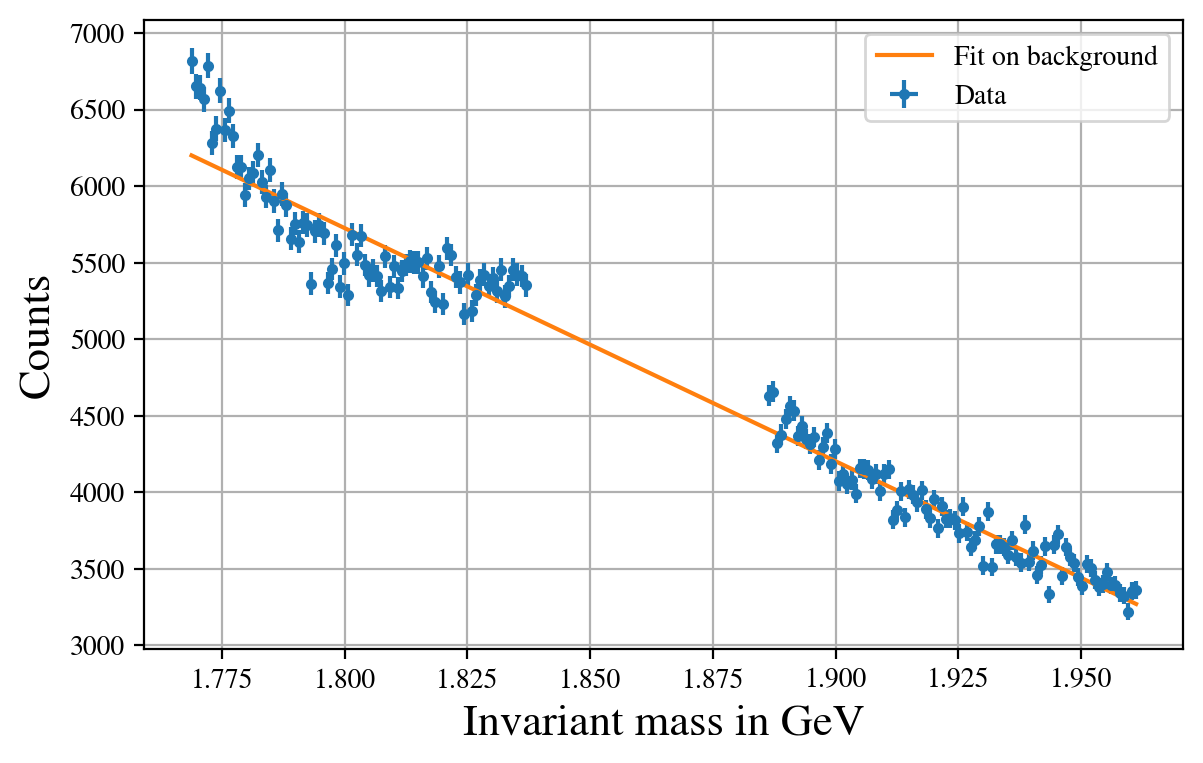

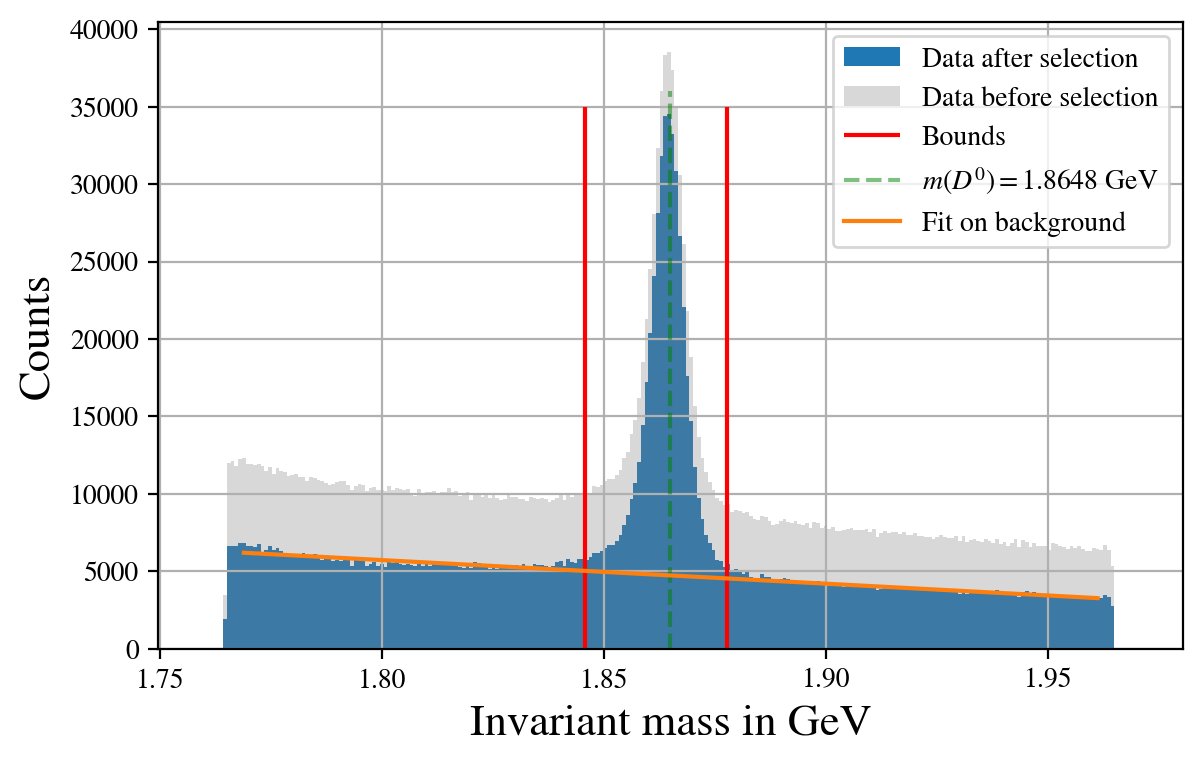

In [184]:
# determine the purity of the data set

# extract data
counts, bin_edges = np.histogram(df.D0m_inv, bins=nbins, range=(1.76,1.97))
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])
dcounts = np.sqrt(counts)

# data to plot
sliced_centers = bin_centers
sliced_centers = np.delete(sliced_centers, np.s_[start-10:end+10])
sliced_counts = counts
sliced_counts = np.delete(sliced_counts, np.s_[start-10:end+10])

# define model to fit the background with
def lin_model(x, m, n):
    return m*x+n


# plot only background data and fit-result
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

params, errors, chi = fit_data(sliced_centers[10:-10], sliced_counts[10:-10], np.sqrt(sliced_counts[10:-10]), 0, lin_model, m=-10, n=50)

plt.xlabel(r"Invariant mass in GeV",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="upper right")
plt.grid(True, 'both')
#plt.savefig('D0_inv_mass_fit.pdf')


# plot everything
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

# data before/after selection
plt.hist(df.D0m_inv, range=(1.76,1.97), bins=nbins, label="Data after selection")
plt.hist(df_pre_q_cut.D0m_inv, range=(1.76,1.97), bins=nbins, label="Data before selection", alpha=.3, color='grey')

# all of the data outside the bounds is considered background
plt.vlines(1.76+0.21*start/nbins, 0 , 35000,color="red", label="Bounds")
plt.vlines(1.76+0.21*end/nbins, 0 , 35000,color="red")

# literature value of the D_0-meson's mass
plt.vlines(1.8648, 0 , 36000,color="green", label=r'$m(D^0) = 1.8648$ GeV', alpha=.5, linestyles='dashed')

# plot fit-result
plt.plot(sliced_centers[10:-10], lin_model(x=sliced_centers[10:-10], m=params[0], n=params[1]), label="Fit on background")

plt.xlabel(r"Invariant mass in GeV",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="upper right")
plt.grid(True, 'both')
#plt.savefig('D0_inv_mass_hist.pdf')


# calculate background events within bounds
N_bgd = 1190.48*((bin_centers[end]**2 * 0.5 * (params[0]) + params[1] * bin_centers[end]) - 
                 (bin_centers[start]**2 * 0.5 * params[0] + params[1] * bin_centers[start]))
delta_N_bdg = 1190.48 * np.sqrt(((bin_centers[end]**2-bin_centers[start]**2)*.5*errors[0])**2 + ((bin_centers[end]-bin_centers[start])*errors[1])**2)

# count candidate events, i.e. all events within bounds
N_cand = np.sum(counts[start:end])

# calculate signal events and purity
N_sig = N_cand - N_bgd
purity = N_sig/N_cand
delta_purity = np.sqrt(purity*(1-purity)/N_cand)

print('')
print(f'Background events: {N_bgd} +- {delta_N_bdg}')
print(f'Candidate events: {N_cand} +- {np.sqrt(N_cand)}')
print(f'Purity: {purity} +- {delta_purity}')

### Reconstruction of the $D^{*+}$ decay

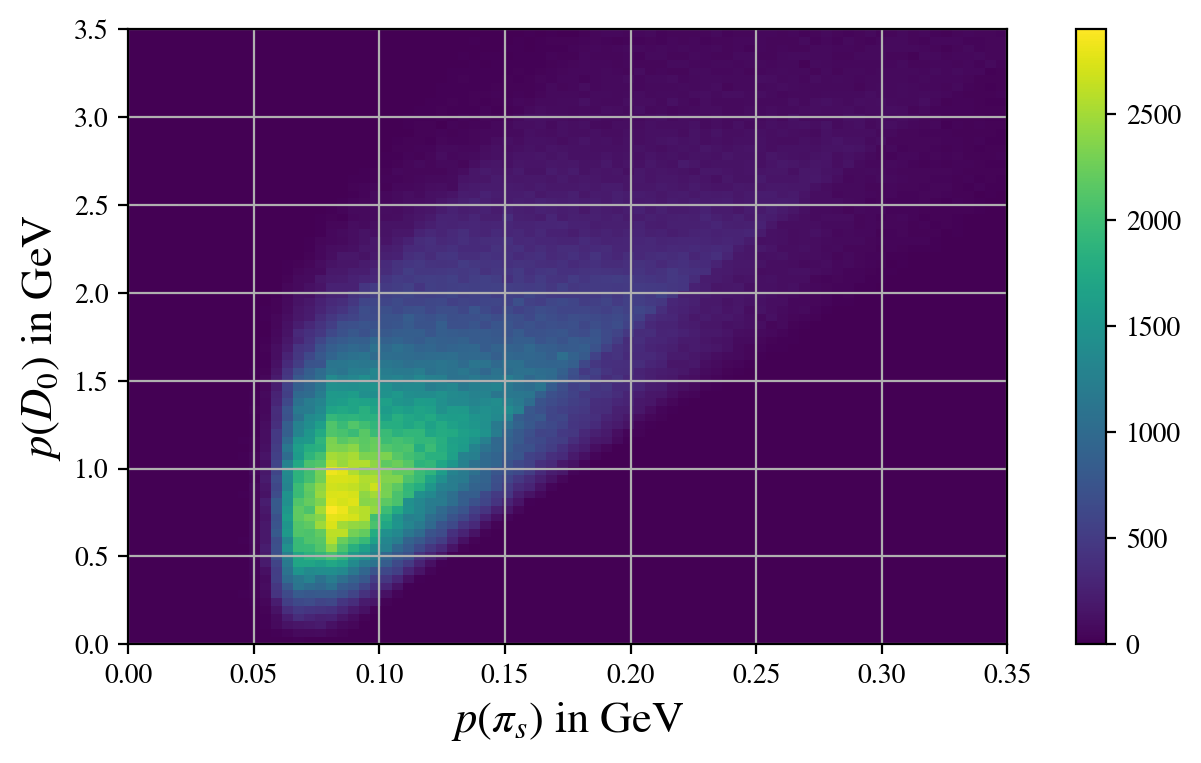

In [185]:
# scatter plot of D0-momentum vs. slow pion momentum

# D0 momentum as sum of pion and kaon momenta
k1 = df["pi_px"].to_numpy()
k2 = df["pi_py"].to_numpy()
k3 = df["pi_pz"].to_numpy()
k4 = df["k_px"].to_numpy()
k5 = df["k_py"].to_numpy()
k6 = df["k_pz"].to_numpy()
l1 = k1 + k4
l2 = k2 + k5
l3 = k3 + k6
D0_mom = np.sqrt(l1**2+l2**2+l3**2)

# slow pion momentum
pis_mom = df["pis_p"].to_numpy()

# plot
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist2d(pis_mom, D0_mom, bins=80, range=[[0, .35], [0, 3.5]])
plt.colorbar()

plt.xlabel(r"$p(\pi_s)$ in GeV",fontsize=16)
plt.ylabel(r"$p(D_0)$ in GeV",fontsize=16)
plt.grid(True, 'both')
#plt.savefig('D0_pis_2D_hist.pdf')

C:\Users\marce\AppData\Local\Temp\ipykernel_18332\3492800972.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Dplusm_inv"] = np.sqrt((df["pi_E"] + df["k_E"]+df["pis_E"])**2 - (df["pi_px"] + df["k_px"]+df["pis_px"])**2 -


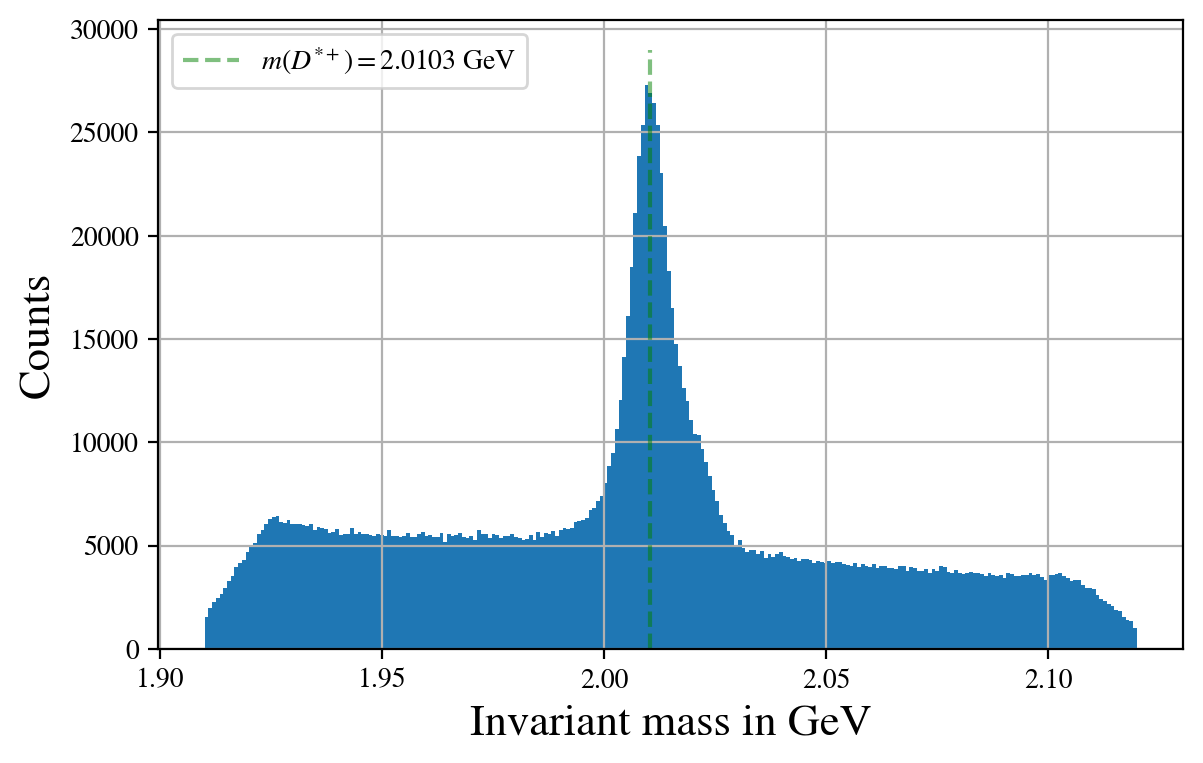

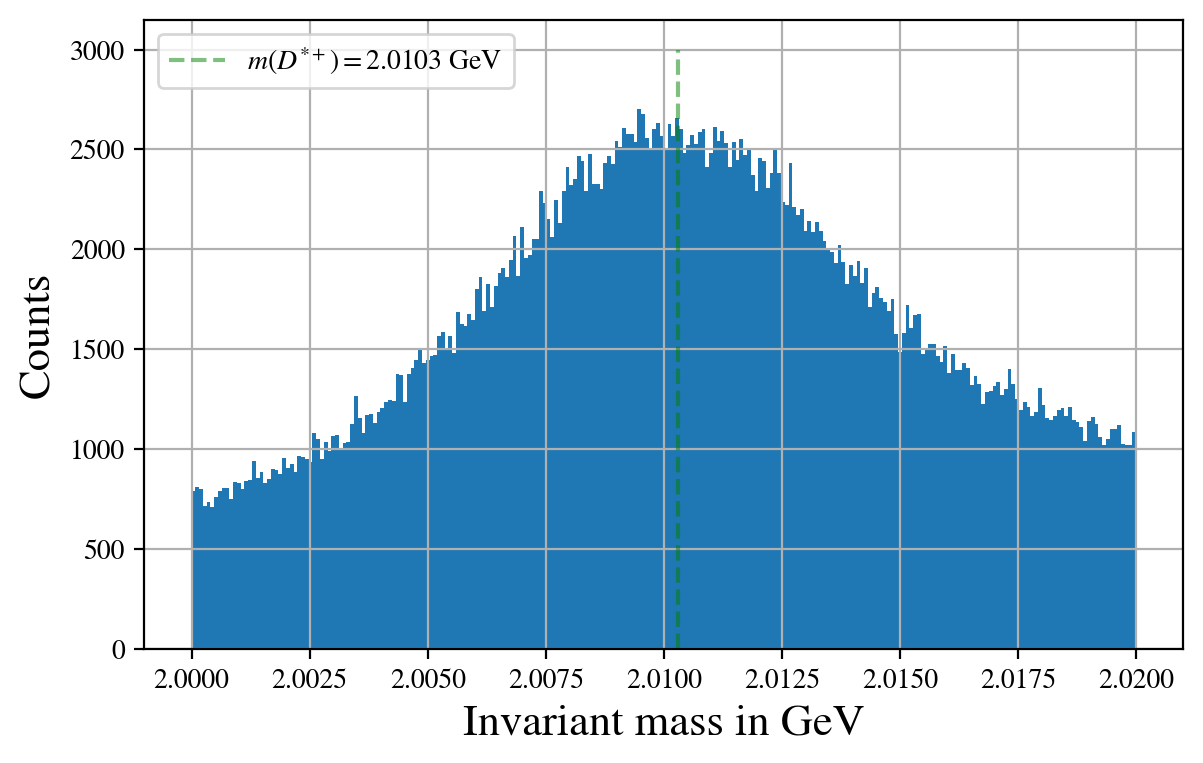

In [186]:
# invariant mass of the D*+ decay candidates

df["Dplusm_inv"] = np.sqrt((df["pi_E"] + df["k_E"]+df["pis_E"])**2 - (df["pi_px"] + df["k_px"]+df["pis_px"])**2 -
                           (df["pi_py"] + df["k_py"]+df["pis_py"])**2 - (df["pi_pz"] + df["k_pz"]+df["pis_pz"])**2)

# plot the complete spectrum
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(df.Dplusm_inv, range=(1.91,2.12), bins=nbins)
plt.vlines(2.0103, 0 , 29000,color="green", label=r'$m(D^{*+}) = 2.0103$ GeV', alpha=.5, linestyles='dashed')

plt.xlabel(r"Invariant mass in GeV",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="upper left")
plt.grid(True, 'both')
#plt.savefig('Dplus_inv_mass_hist.pdf')

# plot of only the relevant peak
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(df.Dplusm_inv, range=(2,2.02), bins=nbins)
plt.vlines(2.0103, 0 , 3000,color="green", label=r'$m(D^{*+}) = 2.0103$ GeV', alpha=.5, linestyles='dashed')

plt.xlabel(r"Invariant mass in GeV",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="upper left")
plt.grid(True, 'both')
#plt.savefig('Dplus_inv_mass_zoom.pdf')


In [187]:
# calculate invariant mass differences and only choose data within the relevant peaks

df["Dm_inv_diff"]=df["Dplusm_inv"]-df["D0m_inv"]
df_pre_cut = df

df = df[df["Dplusm_inv"]<2.03]
df = df[df["Dplusm_inv"]>1.99]
df = df[df["D0m_inv"]<1.8776]
df = df[df["D0m_inv"]>1.84568]

df= df[df["pis_q"] == df["pi_q"]]
df= df[df["pis_q"] != df["Ls_q"]]

C:\Users\marce\AppData\Local\Temp\ipykernel_18332\3121950230.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Dm_inv_diff"]=df["Dplusm_inv"]-df["D0m_inv"]


parameter 0: 396.4 ± 2.9
parameter 1: 0.13998 ± 0.00019
parameter 2: 531.0 ± 78.0
χ²/ndf = 2.2998035493303464
Background: 181671.97694847605 +- 1329.0890758102462
Candidate: 153606 +- 391.92601342600364
Purity: 0.8830809127425615 +- 0.0008198584310166872


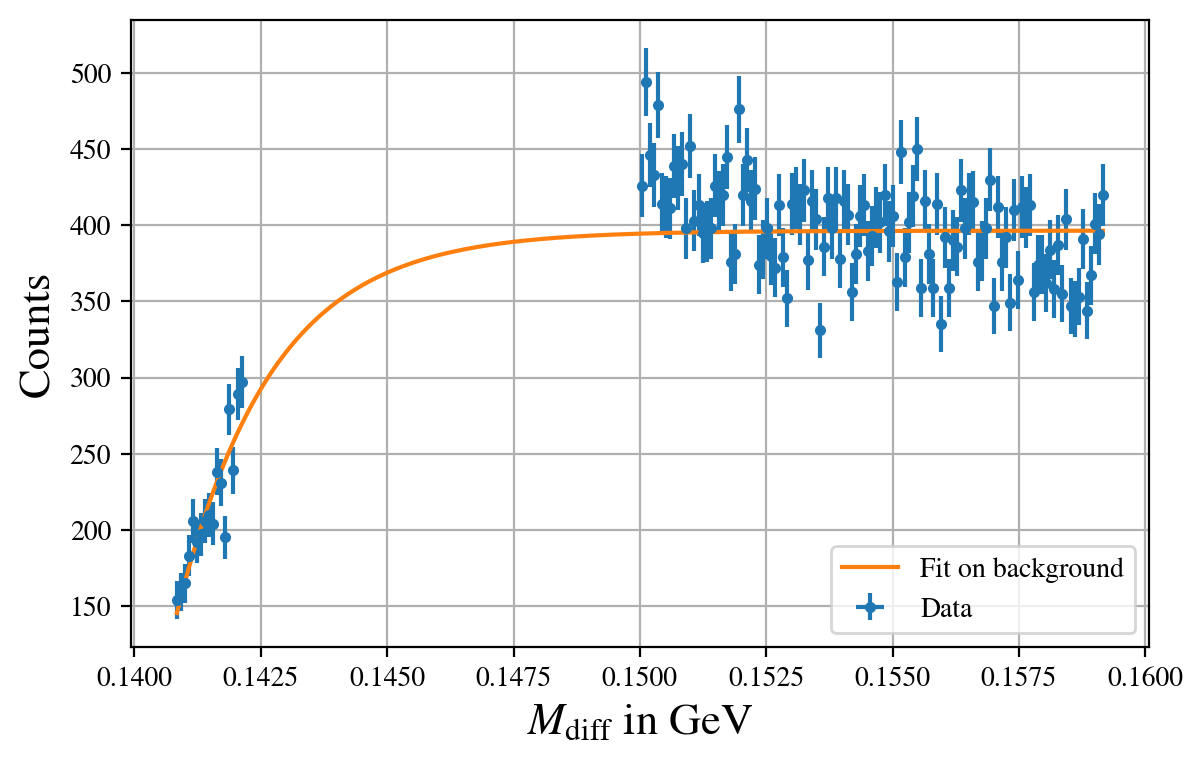

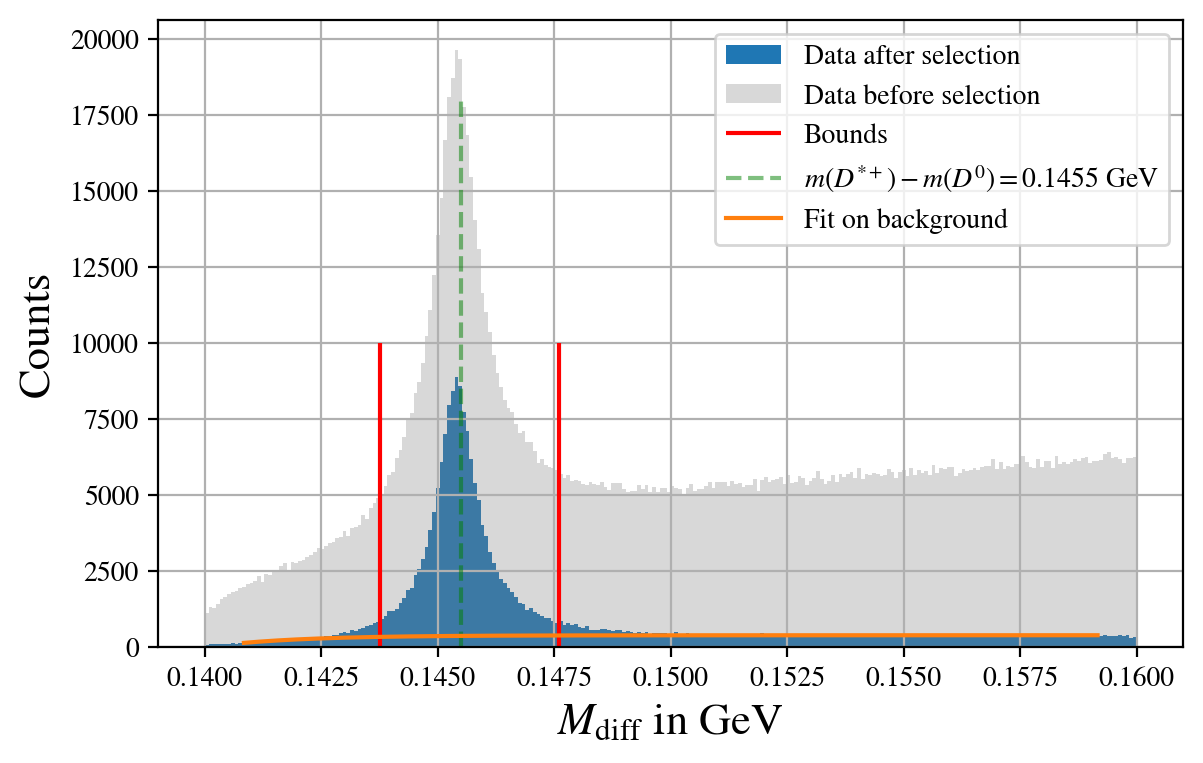

In [188]:
# take care of the background

# model for the background and its integral to count background events
def exp_model(x, A, B, C):
    return A*(1 - np.exp(-(x-B)*C))

def int_exp_model(x, A, B, C):
    return A*(x + np.exp(-(x-B)*C) / C)


# extract data
counts2, bin_edges2 = np.histogram(df.Dm_inv_diff, bins=nbins, range=(0.14,0.16))
bin_centers2 = 0.5*(bin_edges2[1:] + bin_edges2[:-1])
dcounts2 = np.sqrt(counts2)

# choose bounds of the peak
start2 = 47
end2 = 95

# choose data to plot later
sliced_centers2 = bin_centers2
sliced_centers2 = np.delete(sliced_centers2, np.s_[start2-20:end2+30])
sliced_counts2= counts2
sliced_counts2 = np.delete(sliced_counts2, np.s_[start2-20:end2+30])


# plot background and corresponding fit
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

params2, errors2, chi2 = fit_data(sliced_centers2[10:-10], sliced_counts2[10:-10], np.sqrt(sliced_counts2[10:-10]), 0, exp_model, False, A=3000, B=.14, C=253)
plt.plot(bin_centers2[10:-10], exp_model(x=bin_centers2[10:-10], A=params2[0], B=params2[1], C=params2[2]), label="Fit on background")

plt.xlabel(r"$M_\text{diff}$ in GeV",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="lower right")
plt.grid(True, 'both')
#plt.savefig('mass_diff_fit.pdf')


# plot everything
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(df.Dm_inv_diff, range=(0.14,0.16), bins=nbins, label="Data after selection")
plt.hist(df_pre_cut.Dm_inv_diff, range=(0.14,0.16), bins=nbins, label="Data before selection", alpha=.3, color='grey')

plt.vlines(0.14+0.02*start2/nbins, 0 , 10000,color="red", label="Bounds")
plt.vlines(0.14+0.02*end2/nbins, 0 , 10000,color="red")
plt.vlines(.1455, 0 , 18000,color="green", label=r'$m(D^{*+}) - m(D^0) = 0.1455$ GeV', alpha=.5, linestyles='dashed')

plt.plot(bin_centers2[10:-10], exp_model(x=bin_centers2[10:-10], A=params2[0], B=params2[1], C=params2[2]), label="Fit on background")

plt.xlabel(r"$M_\text{diff}$ in GeV",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="upper right")
plt.grid(True, 'both')
#plt.savefig('mass_diff_hist.pdf')


# calculate counts

# background events and corresponding error
prefactor_intexp = nbins / 0.02
N_bgd2 = prefactor_intexp * (int_exp_model(x=bin_centers2[end2],A=params2[0], B=params2[1], C=params2[2]) -
                             int_exp_model(x=bin_centers2[start2],A=params2[0], B=params2[1], C=params2[2]))
def delta_C(x):
    return 78*np.exp(531*(0.13998-x)) * (396.4*(0.13998-x)/531 - 396.4/531**2)
delta_N_bgd2 = np.sqrt(prefactor_intexp * (delta_C(bin_centers2[end2])-delta_C(bin_centers2[start2]))**2 + (2.9/396.4)**2*(N_bgd)**2)

# candidate events
N_cand2 = np.sum(counts2[start2:end2])

# signal events and purity
N_sig2 = N_cand2 - N_bgd2
purity2 = N_sig2/N_cand2
delta_purity2 = np.sqrt(purity2*(1-purity2)/N_cand2)

print(f'Background: {N_bgd} +- {delta_N_bgd2}')
print(f'Candidate: {N_cand2} +- {np.sqrt(N_cand2)}')
print(f'Purity: {purity2} +- {delta_purity2}')

### Full decay chain

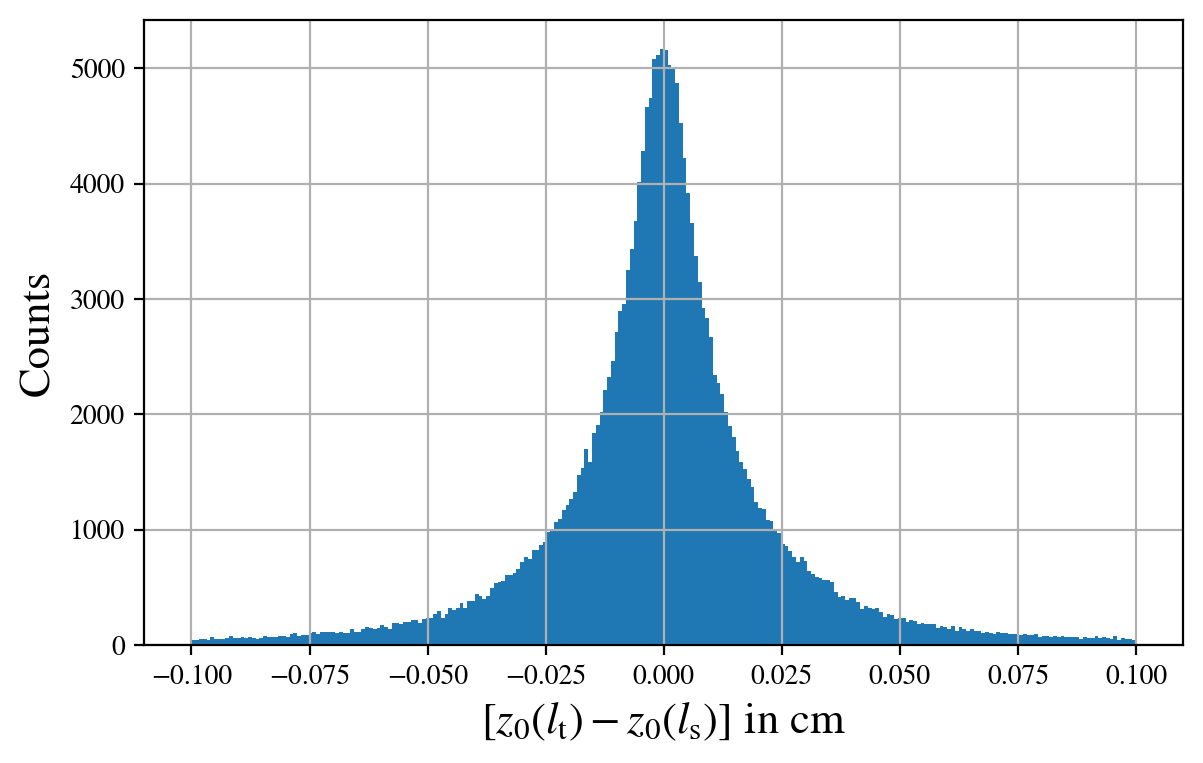

In [189]:
# z0 positions, i.e. positions of detection

# tag and signal lepton
z_t = df.Lt_z0
z_s = df.Ls_z0

lept_z_diff = z_t - z_s

# plot difference
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(lept_z_diff, bins=nbins, range=(-.1, .1))

plt.xlabel(r"$[z_{0} (l_\text{t}) - z_{0} (l_\text{s})]$ in cm",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.grid(True, 'both')
#plt.savefig('z0_lept_hist.pdf')

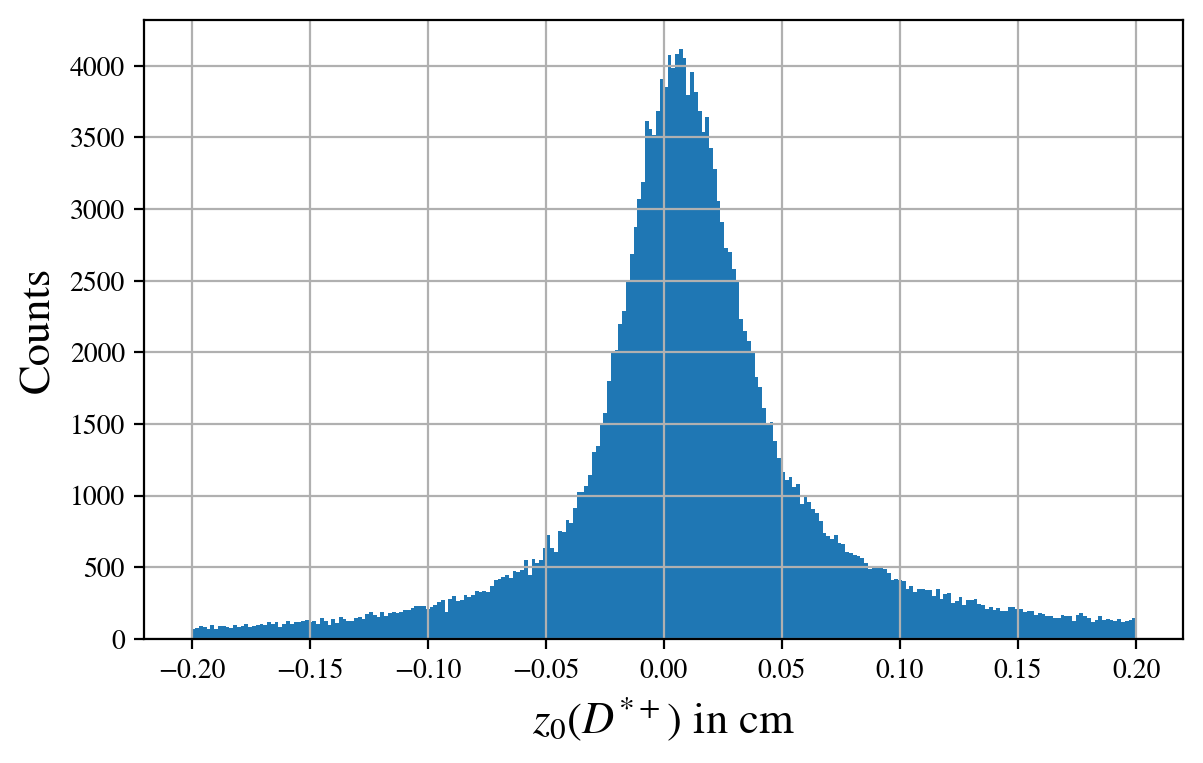

In [190]:
# average D*+ postions

# calculate D*+ positions as average of its decay products' positions
df["Dplus_z0"] = (df.pis_z0 + df.pi_z0 + df.k_z0)/3
z_Dplus = df["Dplus_z0"]

fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(z_Dplus, bins=nbins, range=(-.2, .2))

plt.xlabel(r"$z_{0} (D^{*+})$ in cm",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.grid(True, 'both')
#plt.savefig('z0_Dplus_hist.pdf')

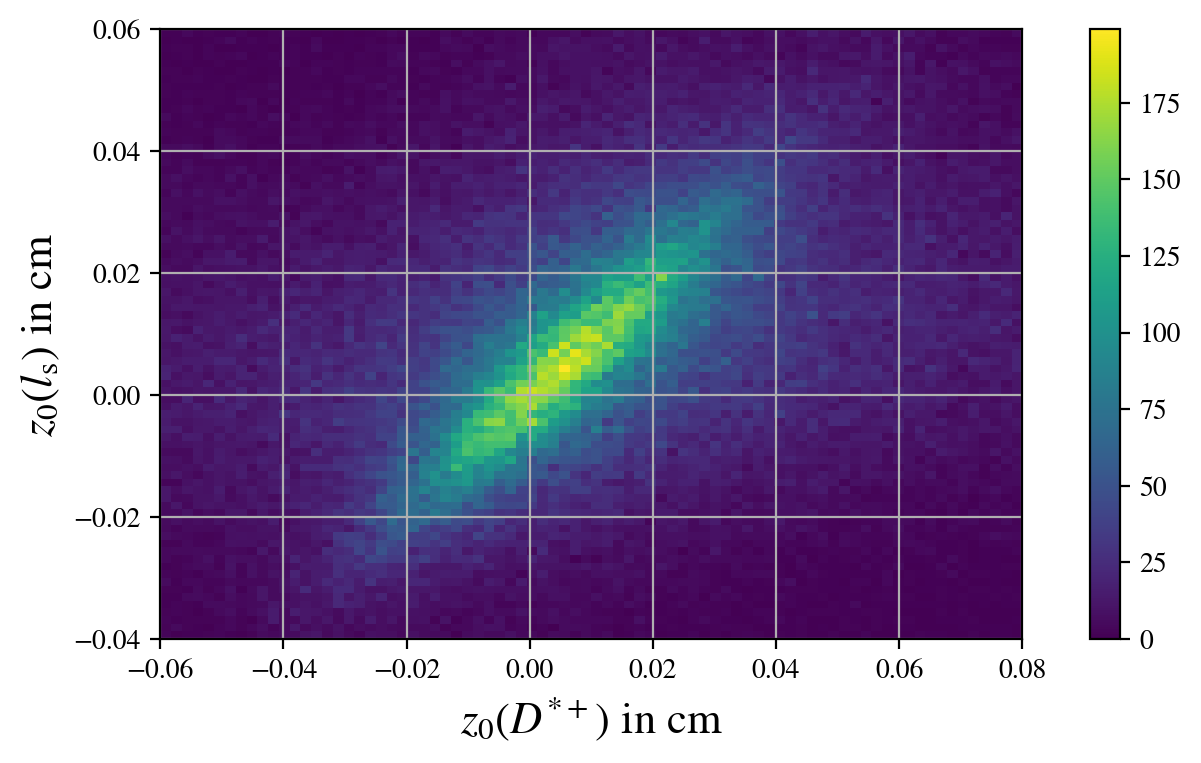

In [191]:
# scatter plot of z0 positions of signal lepton and D*+

fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist2d(z_Dplus, z_s, bins=80, range=[[-.06, .08], [-.04, .06]])
plt.colorbar()

plt.xlabel(r"$z_{0} (D^{*+})$ in cm",fontsize=16)
plt.ylabel(r"$z_{0} (l_\text{s})$ in cm",fontsize=16)
plt.grid(True, 'both')
#plt.savefig('sig_Dplus_2D_hist.pdf')

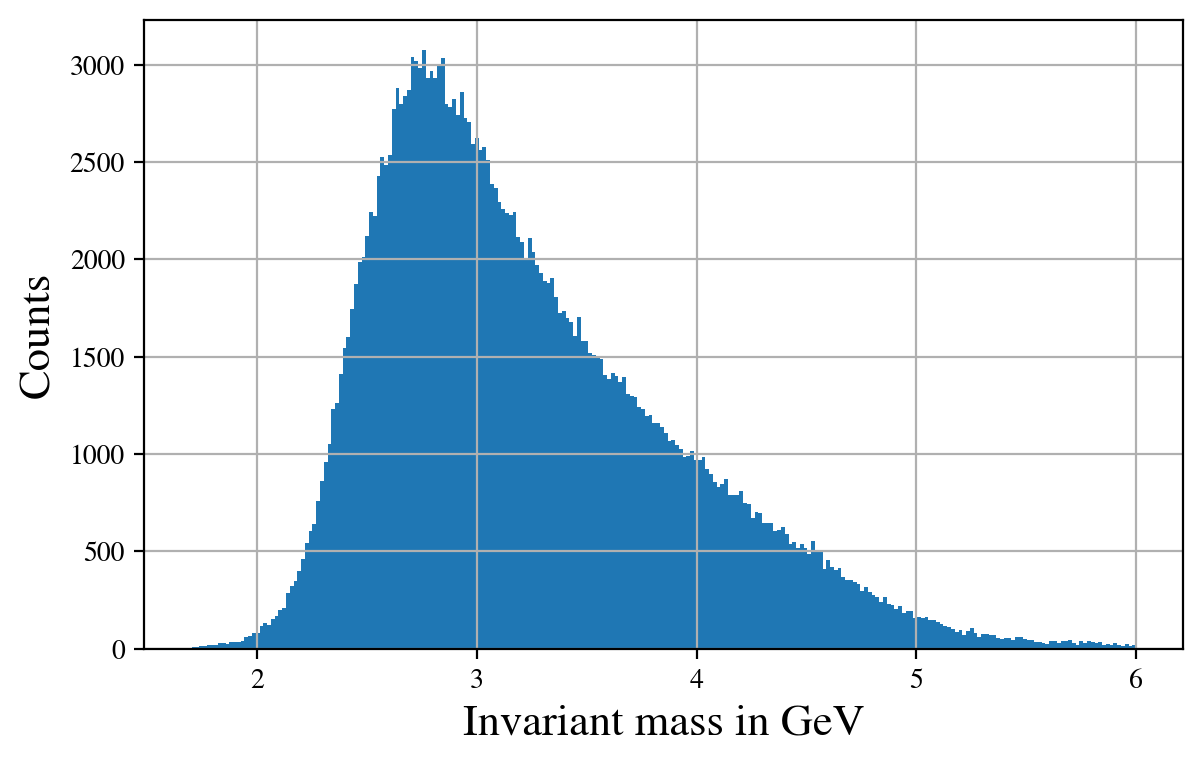

In [192]:
# invariant mass of the B-mesons decay products

df["B0_inv"] = np.sqrt((df["pi_E"] + df["k_E"]+df["pis_E"]+df["Ls_E"])**2 - (df["Ls_px"]+df["pi_px"] + df["k_px"]+df["pis_px"])**2 -
                       (df["Ls_py"]+df["pi_py"] + df["k_py"]+df["pis_py"])**2 - (df["Ls_py"]+df["pi_pz"] + df["k_pz"]+df["pis_pz"])**2)
B0_inv = df.B0_inv.to_numpy()

fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(df.B0_inv, range=(1.7,6), bins=nbins)

plt.xlabel(r"Invariant mass in GeV",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.grid(True, 'both')
#plt.savefig('B0_m_inv_hist.pdf')

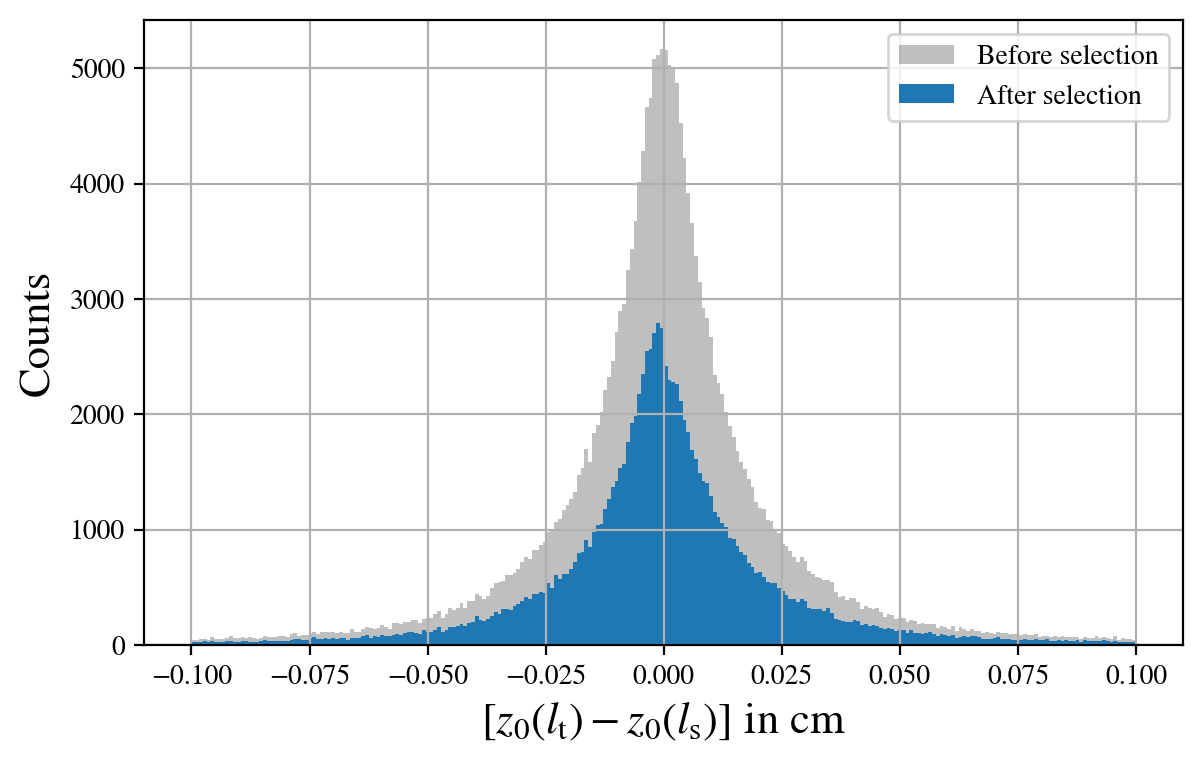

In [193]:
# selection and above plots again

# select data with correct signal and tag notion
df = df[np.abs(df.Ls_z0 - df.Dplus_z0) < np.abs(df.Lt_z0 - df.Dplus_z0)]

# select data based on charge conservation
df = df[df.Ls_q + df.k_q + df.pi_q + df.pis_q == 0]

z_t2 = df.Lt_z0
z_s2 = df.Ls_z0

lept_z_diff2 = z_t2 - z_s2

fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(lept_z_diff, bins=nbins, range=(-.1, .1), alpha=.5, label='Before selection', color='grey')
plt.hist(lept_z_diff2, bins=nbins, range=(-.1, .1), label='After selection')

plt.xlabel(r"$[z_{0} (l_\text{t}) - z_{0} (l_\text{s})]$ in cm",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="upper right")
plt.grid(True, 'both')
#plt.savefig('z0_signal_tag_hist.pdf')

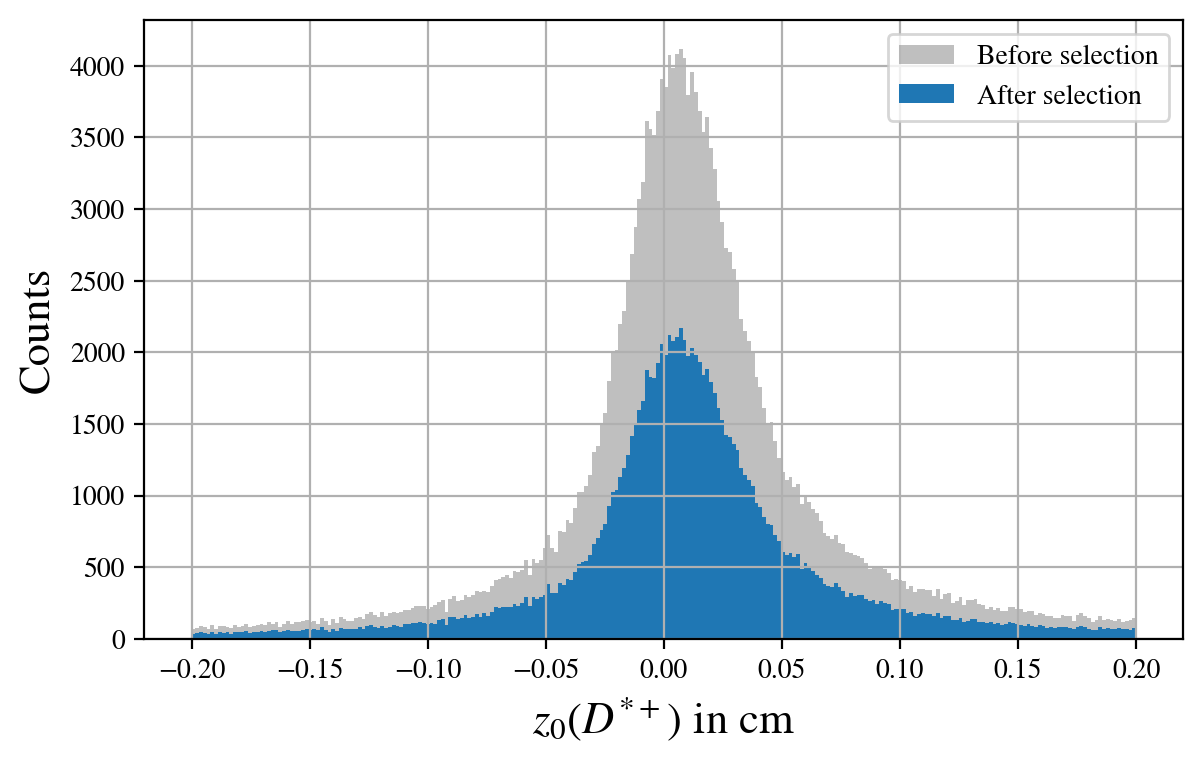

In [194]:
df["Dplus_z02"] = (df.pis_z0 + df.pi_z0 + df.k_z0)/3
z_Dplus2 = df["Dplus_z02"]

fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(z_Dplus, bins=nbins, range=(-.2, .2), alpha=.5, label='Before selection', color='grey')
plt.hist(z_Dplus2, bins=nbins, range=(-.2, .2), label='After selection')

plt.xlabel(r"$z_{0} (D^{*+})$ in cm",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="upper right")
plt.grid(True, 'both')
#plt.savefig('z0_Dplus_hist.pdf')

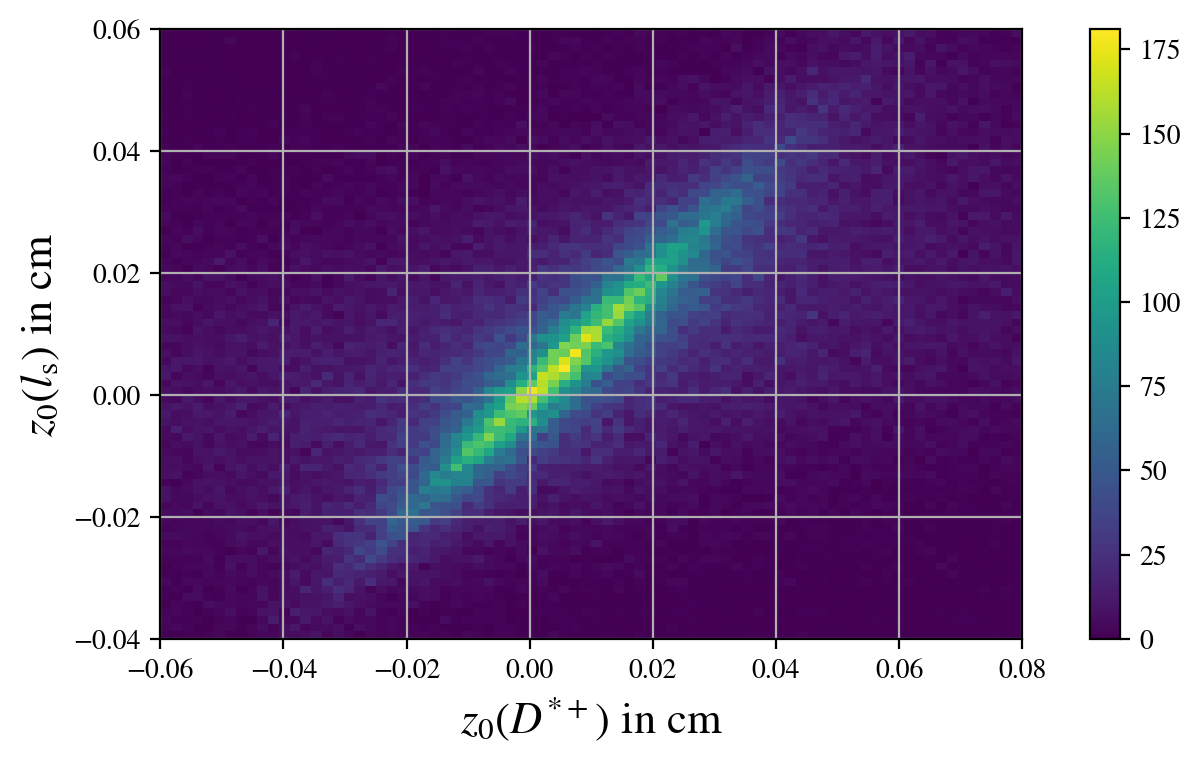

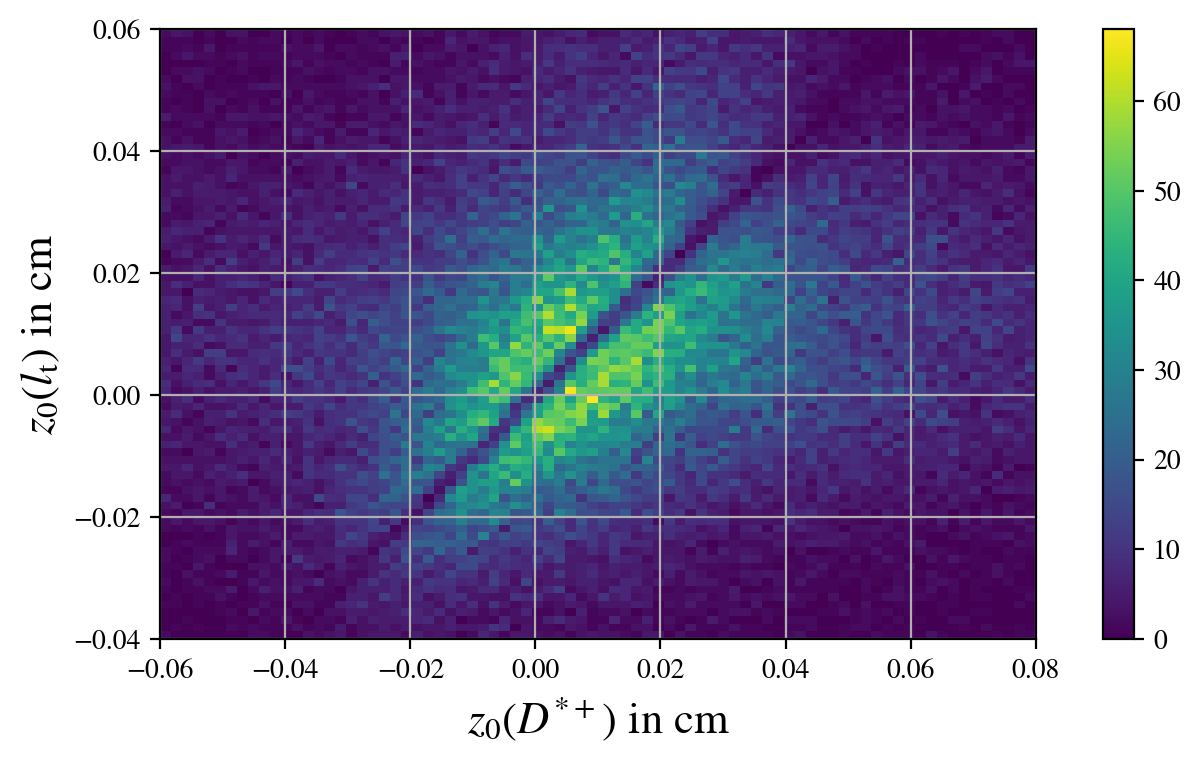

In [195]:
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist2d(z_Dplus2, z_s2, bins=80, range=[[-.06, .08], [-.04, .06]])
plt.colorbar()

plt.xlabel(r"$z_{0} (D^{*+})$ in cm",fontsize=16)
plt.ylabel(r"$z_{0} (l_\text{s})$ in cm",fontsize=16)
plt.grid(True, 'both')
#plt.savefig('sig_Dplus_2D_hist_after.pdf')


fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist2d(z_Dplus2, z_t2, bins=80, range=[[-.06, .08], [-.04, .06]])
plt.colorbar()

plt.xlabel(r"$z_{0} (D^{*+})$ in cm",fontsize=16)
plt.ylabel(r"$z_{0} (l_\text{t})$ in cm",fontsize=16)
plt.grid(True, 'both')
#plt.savefig('tag_Dplus_2D_hist_after.pdf')

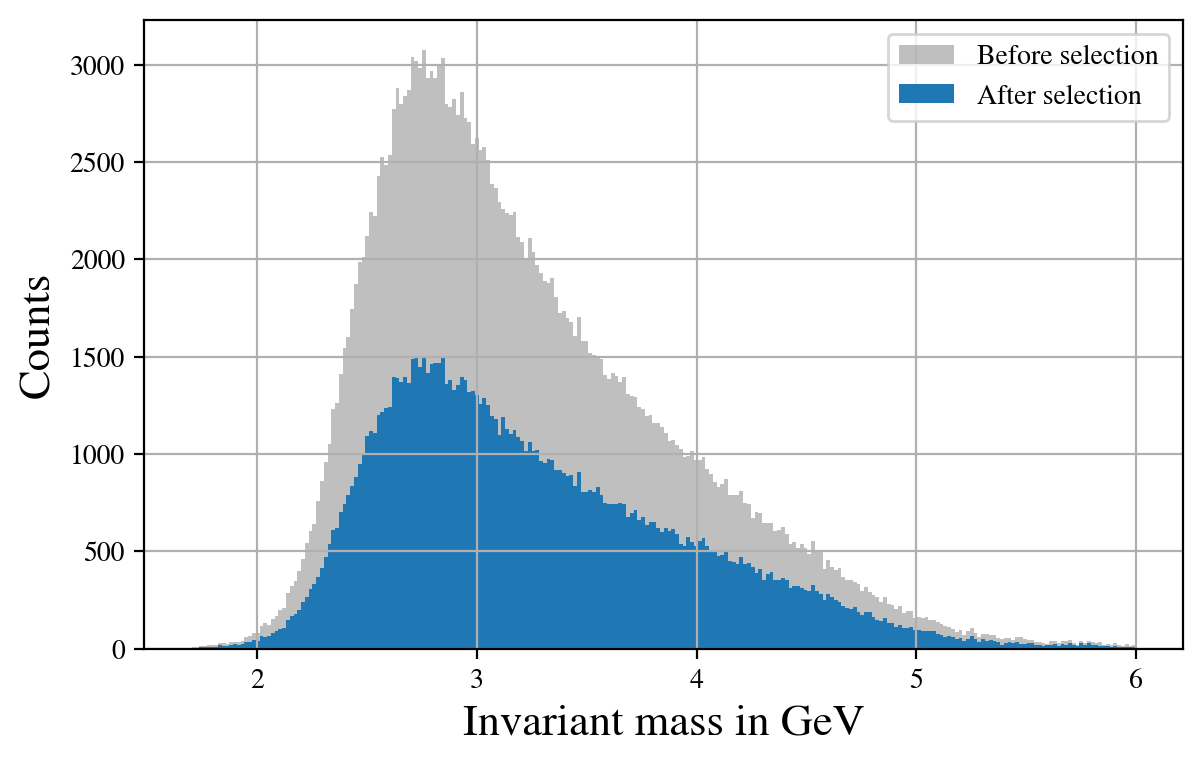

In [196]:
df["B0_inv2"] = np.sqrt((df["pi_E"] + df["k_E"]+df["pis_E"]+df["Ls_E"])**2 -
                        (df["Ls_px"]+df["pi_px"] + df["k_px"]+df["pis_px"])**2 -
                        (df["Ls_py"]+df["pi_py"] + df["k_py"]+df["pis_py"])**2 -
                        (df["Ls_py"]+df["pi_pz"] + df["k_pz"]+df["pis_pz"])**2)


fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

plt.hist(B0_inv, range=(1.7,6), bins=nbins, alpha=.5, label='Before selection', color='grey')
plt.hist(df.B0_inv2, range=(1.7,6), bins=nbins, label='After selection')

plt.xlabel(r"Invariant mass in GeV",fontsize=16)
plt.ylabel(r"Counts",fontsize=16)
plt.legend(loc="upper right")
plt.grid(True, 'both')
#plt.savefig('B0_m_inv_hist.pdf')

### Oscillation Frequency

parameter 0: 0.1238 ± 0.0093
parameter 1: 0.483 ± 0.05
parameter 2: 0.46 ± 0.24
parameter 3: -0.091 ± 0.013
χ²/ndf = 1.0371517572106772


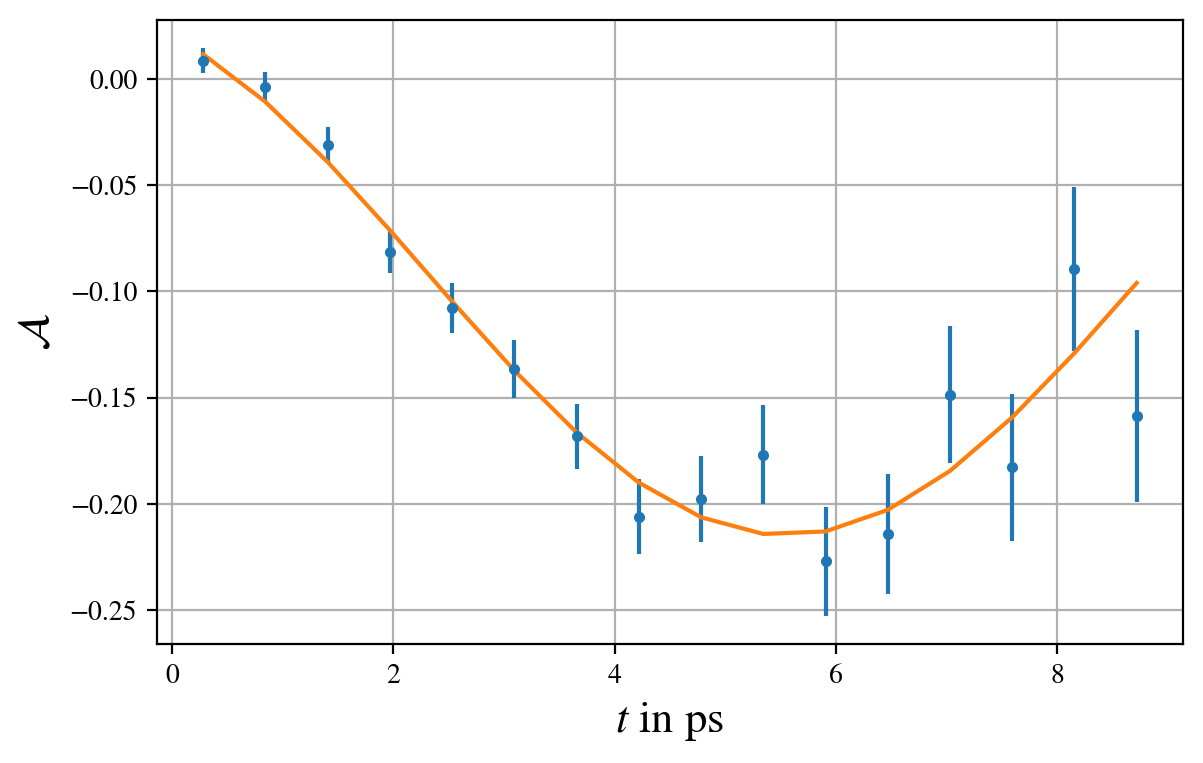

In [197]:
# model for B-meson oscillation
def cos_model(x, D, dM, B, C):
    return D * np.cos(dM * x + B) + C


# sort oscillated and non-oscillated events based on charges
non_osc = df[df.Ls_q != df.Lt_q]
osc = df[df.Ls_q == df.Lt_q]

# histogram parameters, optimized by hand
bin_number = 16
bound = 9

N_osc, times_edges = np.histogram(osc.deltat, bins=bin_number, range=(0,bound))
times = 0.5*(times_edges[1:] + times_edges[:-1])
N_non_osc, _ = np.histogram(non_osc.deltat, bins=bin_number, range=(0,bound))

# calculate asymmetry function
A = (N_non_osc - N_osc) / (N_non_osc + N_osc)
Delta_A = np.sqrt((2 * N_osc * np.sqrt(N_non_osc)/(N_non_osc + N_osc)**2)**2+(2 * N_non_osc * np.sqrt(N_osc)/(N_non_osc + N_osc)**2)**2)


# plot final fit results
fig, ax = plt.subplots(1, 1, gridspec_kw = {'wspace':0.02, 'hspace':0.05}, figsize=(5.9,3.7), squeeze=False, constrained_layout=True, dpi=200)
ax1=ax[0,0]

fit_data(times, A, Delta_A, 0, cos_model, True, D=.2, dM=1, B=0, C=0)

plt.xlabel(r"$t$ in ps",fontsize=16)
plt.ylabel(r"$\mathcal{A}$",fontsize=16)
plt.grid(True, 'both')
#plt.savefig('asym_fit.pdf')
